# Avengers Facial Recognition

This project uses State of the Art Facial Recognition model pruposed by Google called **FaceNet**. Facenet uses deep convolutional networks along with triplet loss to achieve state of the art accuracy. 

In this project we used **NN4 Small2 v1** , an Inception model with 96x96 images as input. We have used a pretrained model from [OpenFacePytorch](https://github.com/thnkim/OpenFacePytorch), which was trained on OpenFace Dataset. Transfer Learning was then applied to train the classifier on the Avengers Dataset.

We have also used **MTCNN** (MultiTask Cascaded Convolution Network) from [facenet-pytorch](https://github.com/timesler/facenet-pytorch) to crop and align the faces

In [ ]:
!pip install facenet-pytorch

In [2]:
import os 
import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import facenet_pytorch
from facenet_pytorch import MTCNN
from tqdm.notebook import tqdm
import torch.nn as nn
import random

%matplotlib inline


# Check if CUDA GPU is available
useCuda = torch.cuda.is_available()
if useCuda:
    print('CUDA is avialable')
    device = torch.device('cuda:0')
else:
    print('CUDA is not avialable')
    device = torch.device('cpu')
    

CUDA is avialable


## Visualize the Avenger Dataset

Plotting some sample images and Drawing an **histogram** of class Frequencies

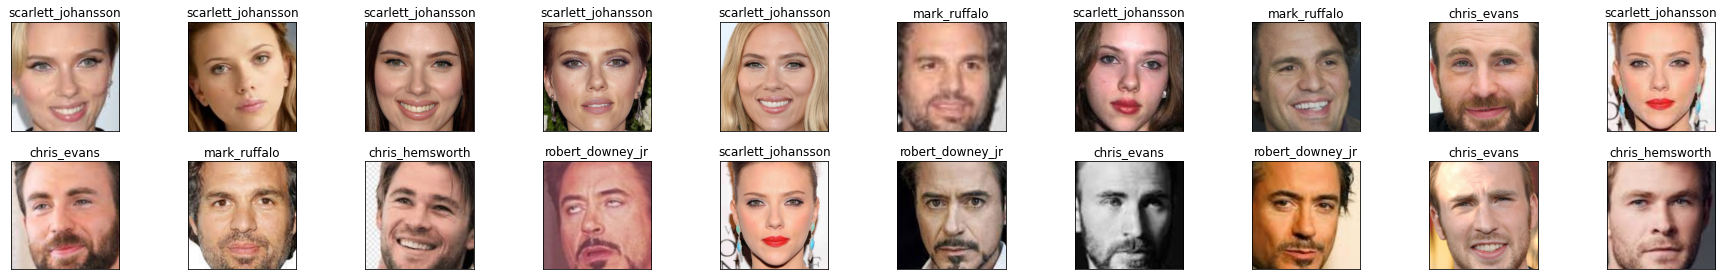

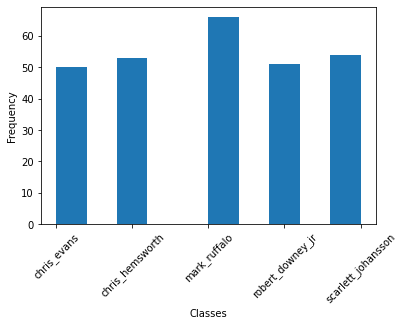

In [5]:
data_dir = 'data/cropped_images'
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}

batch_size = 32
num_workers = 0 if os.name == 'nt' else 8

# Dataloader for Visualization 
vis_dataloader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=batch_size,
                                        num_workers=num_workers,
                                        shuffle=True,
                                        collate_fn=facenet_pytorch.training.collate_pil)
                             
# Load the first batch of images form the dataloader
dataiter = iter(vis_dataloader)
images, labels = dataiter.next()

# Plt the images
fig = plt.figure(figsize=(25, 4))
for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(images[i])
    ax.set_title(dataset.idx_to_class[int(labels[i])])
fig.tight_layout()

## Plot the histogram of the class frequency
labels = []
for i in range(len(dataset)):    
    labels.append(dataset.__getitem__(i)[1])
    
fig , ax = plt.subplots()
plt.xticks(range(len(dataset.idx_to_class)), dataset.idx_to_class.values(), rotation=45)
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
hist = ax.hist(labels)

del vis_dataloader

## Use MTCNN to Crop and Align Images

In this step we apply the MTCNN model to Align and Crop images. The images are then saved in a new directory as specified in `aligned_data_dir`

In [7]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

data_dir = 'data/cropped_images'
aligned_data_dir = data_dir + '_aligned'

# Replace the class label with the new path for storing aligned data
dataset.samples = [(p, p.replace(data_dir, aligned_data_dir)) for p, _ in dataset.samples]

batch_size = 32
num_workers = 0 if os.name == 'nt' else 8

dataloader = torch.utils.data.DataLoader(dataset, 
                                        batch_size=batch_size,
                                        num_workers=num_workers,
                                        collate_fn=facenet_pytorch.training.collate_pil)

# Run MTCNN for all the images and save them in new directory
for i, (image, path) in enumerate(tqdm(dataloader, desc="Converting")):
    mtcnn(image, save_path=path)

# Delete to save memory
del mtcnn
del dataloader

Converting:   0%|          | 0/9 [00:00<?, ?it/s]

## Augmenting the Dataset

As the number of images per class not much, hence we are augmenting the dataset. We are doing this by simply applying **HorizontalFlip** for all the images. Thereby doubling the dataset. We have defined a custom Dataset class `AugmentDataset` which inherits from the `torchvision.datasets.ImageFolder` class.

In [8]:
class AugmentDataset(datasets.ImageFolder):
    def __init__(self, root, transform = None):
        super().__init__(root, transform)
        self.all_labels = [int(x[1]) for x in self.imgs]
        
        self.horizontalTransform = transforms.RandomHorizontalFlip(1)
    
    def __len__(self):
        return 2 * super().__len__()
    
    def __getitem__(self, item):
        if item < super().__len__():
            image, label = super().__getitem__(item)
        else:
            item -= super().__len__()
            image, label = super().__getitem__(item)
            image = self.horizontalTransform(image)
             
        return image, label

## Splitting the Dataset 

Here we have we split the dataset into Train and test sets. We have reserved 80% of the data for training and the rest 20% for testing the model.

We also initialized the respective train and test dataloaders from their respective dataset.

In [9]:
transform = transforms.Compose([transforms.Resize(96),
                                transforms.ToTensor()])

data_dir = 'data/cropped_images'
aligned_data_dir = data_dir + '_aligned'

# dataset = datasets.ImageFolder(aligned_data_dir, transform=transform)
dataset = AugmentDataset(aligned_data_dir, transform=transform)
idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}

total_count = len(dataset)
train_count = int(0.8 * total_count)
test_count = total_count - train_count

train_dataset, test_dataset = torch.utils.data.random_split(dataset,
                                                           [train_count, test_count])
print('Total Images : ', total_count)
print('Num of Train Images : ', len(train_dataset))
print('Num of Test Images : ', len(test_dataset))

batch_size = 64
num_workers = 0 if os.name == 'nt' else 8

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              num_workers=num_workers, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=num_workers, shuffle=True)




Total Images :  548
Num of Train Images :  438
Num of Test Images :  110


## Triplet Loss and Triplet Generator

Here we train the model such it learns the face embeddings $f(x)$ from the image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large.

This can be achieved with a *triplet loss* $L$ as defined by 

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$

This loss minimizes the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ and maximizes the between the anchor image $x^a_i$ and a negative image $x^b_i$ 

The `generate_triplets` function generates these positive and negative images for the entire batch. The current implementation randomly chooses the positive and negative images from the current batch. This can easily be enhanced to select difficult triplets to make the model train better. 

The difficult triplet can be generated by selecting the positive image having the highest distance from the anchor and similarly selcting the negative image having smallest distance from the anchor

In [10]:
# Generate triplets
def generate_triplets(images, labels):
    positive_images = []
    negative_images = []
    batch_size = len(labels)
    
    for i in range(batch_size):
        anchor_label = labels[i]

        positive_list = []
        negative_list = []

        for j in range(batch_size):
            if j != i:
                if labels[j] == anchor_label:
                    positive_list.append(j)
                else:
                    negative_list.append(j)

        positive_images.append(images[random.choice(positive_list)])
        negative_images.append(images[random.choice(negative_list)])

    positive_images = torch.stack(positive_images)
    negative_images = torch.stack(negative_images)
    
    return positive_images, negative_images

class TripletLoss(nn.Module):
    def __init__(self, alpha=0.2):
        super(TripletLoss, self).__init__()
        self.alpha = alpha
    
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor, positive, negative): # (batch_size , emb_size)
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.alpha)
        return losses.mean()


## Define the Model, Optimizer and Loss Function

In [11]:
from loadOpenFace import prepareOpenFace

model = prepareOpenFace(useCuda)
model.eval()
print("Model Loaded")

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = TripletLoss()

Model Loaded


## Training the model

In [12]:
n_epochs = 10

for epoch in tqdm(range(n_epochs), desc="epoch"):
    
    train_loss = 0 
    count = 0
    
    ## Training Loop
    model.train()
    for batch, (images, labels) in enumerate(tqdm(train_dataloader, \
                                             desc="Training", leave=False)):
        
        positives , negatives = generate_triplets(images, labels)
        
        # Move tensor to device
        images, labels = images.to(device), labels.to(device)
        positives, negatives = positives.to(device), negatives.to(device) 
        
        optimizer.zero_grad()
        
        # Seaseme Network
        anchor_out = model(images)
        positive_out = model(positives)
        negative_out = model(negatives)
        
        # Get the loss
        loss = loss_fn(anchor_out, positive_out, negative_out)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.detach().item()
        count =  len(labels)
        

    print('Epoch : %d/%d - Loss: %0.4f' % 
          (epoch+1, n_epochs, train_loss / count))
    train_loss = 0.0

model.eval()
print("Training Done")

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 1/10 - Loss: 0.0853


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 2/10 - Loss: 0.0308


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 3/10 - Loss: 0.0084


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 4/10 - Loss: 0.0095


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 5/10 - Loss: 0.0031


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 6/10 - Loss: 0.0000


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 7/10 - Loss: 0.0008


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 8/10 - Loss: 0.0011


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 9/10 - Loss: 0.0003


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 10/10 - Loss: 0.0004
Training Done


## Testing the Model

In [13]:
def distance(emb1, emb2):
    return torch.sum(torch.square(emb1 - emb2)).numpy()

# Generate Embeddings and label vector
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset))
(images, labels) = next(iter(test_dl))
positives , negatives = generate_triplets(images, labels)

images, labels = images.to(device), labels.to(device)
positives, negatives = positives.to(device), negatives.to(device) 

with torch.no_grad():
    embeddings = model(images)
    
embeddings = embeddings.cpu()
labels = labels.cpu()


### Visualizing the Output

As we can see the model is able to generate the face embeddings for the dataset. Now if had to use just the distance between these embeddings to predict the faces, we would get an accuracy close to **96.5%**.

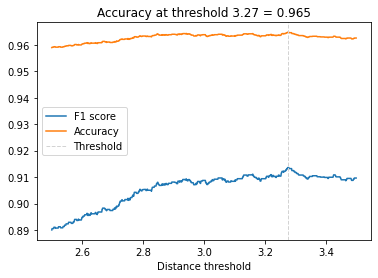

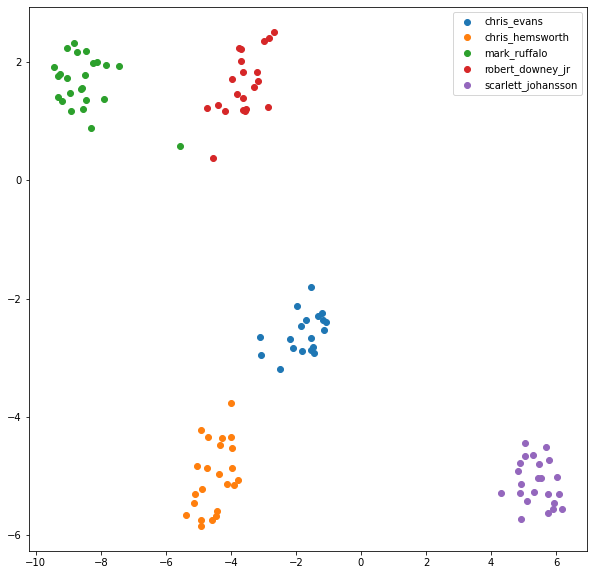

In [16]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(labels)

for i in range(num-1):
    for j in range(1, num):
        distances.append(distance(embeddings[i], embeddings[j]))
        identical.append(1 if labels[i] == labels[j] else 0)

distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(2.5, 3.5, 0.001)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

# Visualize the Result
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embeddings)

plt.figure(figsize=(10,10))


for i, t in enumerate(set(labels.numpy())):
    idx = (t == labels.numpy())
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=idx_to_class[t])

plt.legend(bbox_to_anchor=(1, 1));

# Saving the Model

Saving the model only if the current model accuracy is better or if any previous model checkpoint doesn't exist

In [17]:
chk_path = 'models/AvengersClassifier_FaceNet_nn4_small2_v1.pth'

def save_model(model, chk_path, current_accuracy=1.0):
    '''Saves the model only if model doesnt exist or
       if the model accuracy is better'''
    try:
        checkpoint = torch.load(chk_path)
        if(current_accuracy < checkpoint['accuracy']):
            print("Not Saving, Previous model was better")
            return
        
    except FileNotFoundError:
        print("Previous model not found")
        
    torch.save({
        'model_state_dict' : model.state_dict(),
        'accuracy' : current_accuracy
    }, chk_path)

    print("Model Saved : %s" % chk_path)

save_model(model, chk_path, opt_acc)

Not Saving, Previous model was better


### Loading the Saved Model

In [20]:
# Load the model
chk_path = 'models/AvengersClassifier_FaceNet_nn4_small2_v1.pth'

def load_model(model, chk_path):
    try:
        checkpoint = torch.load(chk_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model Loaded from %s" % chk_path)
        return model
    except FileNotFoundError:
        print("Model checkpoint not found %s" % chk_path)
        return None

model = load_model(model, chk_path)
        

Model Loaded from models/AvengersClassifier_FaceNet_nn4_small2_v1.pth


# Transfer Learning a new classifier

The current model just outputs a face embedding for the image. To create a classifer for the __Avenger Dataset__ we add a new `nn.Linear` layer at the end, this layer takes in the face embedding and predicts the class label.

Since we only need to train the final layer, we freeze the parameters for all layers except the final layer. 

We also defined the **optimizer** to take only the final layer parameters and a `CrossEntropyLoss` function

In [21]:
from collections import OrderedDict

n_classes = len(dataset.class_to_idx)

classifier_model = nn.Sequential(OrderedDict([
                                    ("nn4_small_v2", model),
                                    ("fc",  nn.Linear(736, n_classes))
                                ]))

classifier_model = classifier_model.to(device)

# Freeze the parameters in the nn4_small_v2 layer
for param in classifier_model.parameters():
    param.requires_grad = False

for param in classifier_model.fc.parameters():
    param.requires_grad = True
    

optimizer = optim.Adam(classifier_model.fc.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

### Training the Classifier

In [22]:
def train(n_epochs, dataloader, model, optimizer, loss_fn):
    '''returns Trained classifier model'''
    
    for epoch in tqdm(range(n_epochs), desc="epoch"):

        train_loss = 0.0
        count = 0
        
        # Training loop 
        model.train()
        for batch, (images, labels) in enumerate(tqdm(dataloader, \
                                                 desc="Training", leave=False)):
            
            # Move Tensor to appropriate device
            images, labels = images.to(device), labels.to(device)
 
            optimizer.zero_grad()

            out = model(images)
            
            # Get the loss
            loss = loss_fn(out, labels)
            loss.backward()

            optimizer.step()

            train_loss += loss.detach().item()
            count =  len(labels)


        print('Epoch : %d/%d - Loss: %0.4f' % 
              (epoch+1, n_epochs, train_loss / count))
        train_loss = 0.0

    model.eval()
    print("Training Done")
    return model

classifier_model = train(10 , train_dataloader, classifier_model, optimizer, loss_fn)
    

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 1/10 - Loss: 0.1476


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 2/10 - Loss: 0.0591


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 3/10 - Loss: 0.0287


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 4/10 - Loss: 0.0186


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 5/10 - Loss: 0.0114


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 6/10 - Loss: 0.0094


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 7/10 - Loss: 0.0079


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 8/10 - Loss: 0.0079


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 9/10 - Loss: 0.0060


Training:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch : 10/10 - Loss: 0.0065
Training Done


### Testing the Classifier

In [24]:
def test(dataloader, model, loss_fn):
    
    test_loss = 0.0
    total = 0
    correct = 0

    # Testing loop 
    model.eval()
    for batch, (images, labels) in enumerate(tqdm(dataloader, \
                                             desc="Testing")):

        # Move Tensor to appropriate device
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            out = model(images)

        loss = loss_fn(out, labels)
        test_loss += loss.detach().item()
        
        # Get the class with max probability
        pred = out.data.max(1, keepdim=True)[1]
        # Compare predictions with true label
        correct += np.sum(np.squeeze(pred.eq(labels.view_as(pred))).cpu().numpy())
        total += labels.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss/total))
    print('Test Accuracy : %d%% (%d/%d)' % (
            100 * correct / total, correct, total))
    
    return(float(correct / total))
    

current_accuracy = test(test_dataloader, classifier_model, loss_fn)
    

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 0.000764

Test Accuracy : 100% (110/110)


As we can see we got a test Accuracy of 100%

# Save the Final Classifier

In [25]:
chk_path = 'models/AvengersClassifier.pth'

def save_model(model, chk_path, idx_to_class, current_accuracy=1.0):
    '''Saves the model only if model doesnt exist or
       if the previous model accuracy was better'''
    try:
        checkpoint = torch.load(chk_path)
        if(current_accuracy < checkpoint['accuracy']):
            print("Not Saving, Previous model was better")
            return
        
    except FileNotFoundError:
        print("Previous model not found")
        
    torch.save({
        'model_state_dict' : model.state_dict(),
        'accuracy' : current_accuracy,
        'idx_to_class': idx_to_class
    }, chk_path)

    print("Model Saved : %s" % chk_path)

save_model(classifier_model, chk_path, idx_to_class, current_accuracy)

Model Saved : models/AvengersClassifier.pth


In [26]:
# Load the model
chk_path = 'models/AvengersClassifier.pth'

def load_model(model, chk_path):
    '''Returns model and idx_to_class dictionary'''
    try:
        checkpoint = torch.load(chk_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Model Loaded from %s" % chk_path)
        return model, checkpoint['idx_to_class']
    except FileNotFoundError:
        print("Model checkpoint not found %s" % chk_path)
        return None

classifier_model, idx_to_class = load_model(classifier_model, chk_path)
        

Model Loaded from models/AvengersClassifier.pth


# Using the Classifer for doing Predictions

In [27]:
from torch.nn import Softmax
from facenet_pytorch import MTCNN
from PIL import Image
from torchvision import transforms 

mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device=device
)

face_transform = transforms.Compose([transforms.Resize(96),
                                    transforms.ToTensor()])

classifier_model = classifier_model.to(device)
classifier_model.eval()

softmax = Softmax(dim=1)

In [29]:
def predict_and_display(img_path, prob_theshold = 0.9):
    img = Image.open(img_path)
    
    # Plt the image
    fig = plt.figure()
    ## Plt original image
    ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    plt.imshow(img)
    ax1.set_title("Original Image")
    
    # Crop, Align and standardize the Image 
    mtcnn_img = mtcnn(img.convert('RGB'))
    
    if mtcnn_img is None:
        plt.show()
        print("ERROR, Could not detect a face in image")
        return
    
    # convert to PIL image
    mtcnn_img = Image.fromarray(np.array(mtcnn_img.permute(1, 2, 0).numpy(), dtype=np.uint8))

    ## Plt MTCNN image
    ax1 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    plt.imshow(mtcnn_img)
    ax1.set_title("MTCNN Image")
    fig.tight_layout()
    plt.show()

    
    # Do the Prediction
    mtcnn_img = face_transform(mtcnn_img).unsqueeze(0)
    mtcnn_img = mtcnn_img.to(device)

    with torch.no_grad():
        label = classifier_model(mtcnn_img)
        label = softmax(label) # To Convert the logit to probabilities

    prob, pred = label.data.max(1, keepdim=True)
    prob, pred = float(prob), int(pred)

    if prob < prob_theshold:
        print("UNKNOWN FACE, but similar to %s with %0.2f%% probability" %
                 (idx_to_class[pred], 100 * prob))
    else:
        print("%s with %0.2f%% probability" %
                 (idx_to_class[pred], 100 * prob))
        

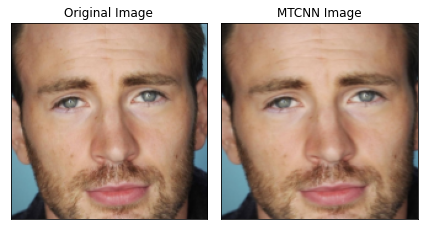

chris_evans with 98.71% probability


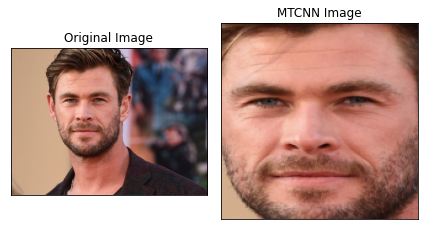

chris_hemsworth with 99.09% probability


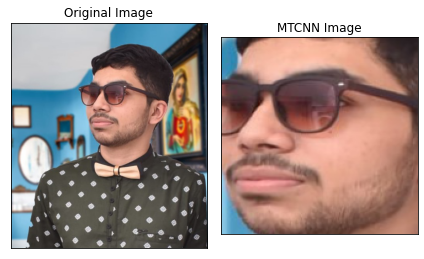

UNKNOWN FACE, but similar to mark_ruffalo with 49.56% probability


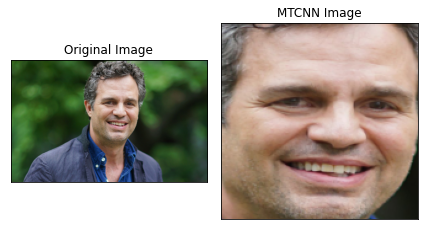

mark_ruffalo with 95.88% probability


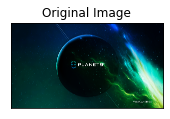

ERROR, Could not detect a face in image


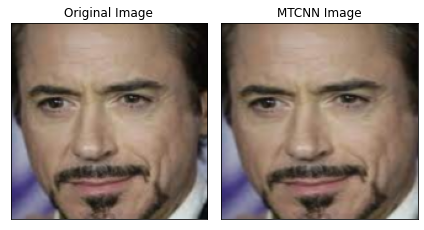

robert_downey_jr with 99.05% probability


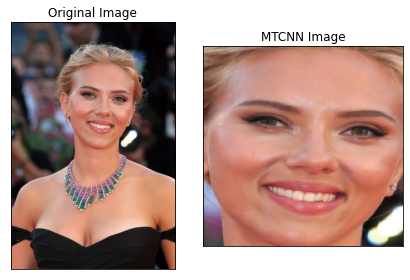

scarlett_johansson with 94.83% probability


In [30]:
import os

img_dir = './sample'
for file in os.listdir(img_dir):
    img_path = os.path.join(img_dir, file)
    predict_and_display(img_path)